# Lab1. Live Human Pose Estimation with OpenVINO™


In [1]:
import collections
import time
from pathlib import Path

import cv2
import numpy as np
from IPython import display
from numpy.lib.stride_tricks import as_strided
import openvino as ov
import utils.notebook_utils as utils

### Download the model

In [2]:
# A directory where the model will be downloaded.
base_model_dir = Path("model")

# The name of the model from Open Model Zoo.
model_name = "human-pose-estimation-0001"
# Selected precision (FP32, FP16, FP16-INT8).
precision = "FP16-INT8"

model_path = base_model_dir / "intel" / model_name / precision / f"{model_name}.xml"

if not model_path.exists():
    model_url_dir = f"https://storage.openvinotoolkit.org/repositories/open_model_zoo/2022.1/models_bin/3/{model_name}/{precision}/"
    utils.download_file(model_url_dir + model_name + ".xml", model_path.name, model_path.parent)
    utils.download_file(
        model_url_dir + model_name + ".bin",
        model_path.with_suffix(".bin").name,
        model_path.parent,
    )

model\intel\human-pose-estimation-0001\FP16-INT8\human-pose-estimation-0001.xml:   0%|          | 0.00/474k [0…

model\intel\human-pose-estimation-0001\FP16-INT8\human-pose-estimation-0001.bin:   0%|          | 0.00/4.03M […

### Load the model

In [3]:
device = utils.device_widget()

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU', 'NPU', 'AUTO'), value='AUTO')

In [12]:
import openvino.properties.hint as hints


# Initialize OpenVINO Runtime
core = ov.Core()
# Read the network from a file.
model = core.read_model(model_path)
# Let the AUTO device decide where to load the model (you can use CPU, GPU as well).
compiled_model = core.compile_model(model=model, device_name=device.value, config={hints.performance_mode(): hints.PerformanceMode.LATENCY})

# Get the input and output names of nodes.
input_layer = compiled_model.input(0)
output_layers = compiled_model.outputs

# Get the input size.
height, width = list(input_layer.shape)[2:]

Input layer has the name of the input node and output layers contain names of output nodes of the network. In the case of OpenPose Model, there is 1 input and 2 outputs: PAFs and keypoints heatmap.

In [13]:
input_layer.any_name, [o.any_name for o in output_layers]

('data', ['Mconv7_stage2_L1', 'Mconv7_stage2_L2'])

### OpenPose Decoder

In [14]:
# code from https://github.com/openvinotoolkit/open_model_zoo/blob/9296a3712069e688fe64ea02367466122c8e8a3b/demos/common/python/models/open_pose.py#L135
class OpenPoseDecoder:
    BODY_PARTS_KPT_IDS = (
        (1, 2),
        (1, 5),
        (2, 3),
        (3, 4),
        (5, 6),
        (6, 7),
        (1, 8),
        (8, 9),
        (9, 10),
        (1, 11),
        (11, 12),
        (12, 13),
        (1, 0),
        (0, 14),
        (14, 16),
        (0, 15),
        (15, 17),
        (2, 16),
        (5, 17),
    )
    BODY_PARTS_PAF_IDS = (
        12,
        20,
        14,
        16,
        22,
        24,
        0,
        2,
        4,
        6,
        8,
        10,
        28,
        30,
        34,
        32,
        36,
        18,
        26,
    )

    def __init__(
        self,
        num_joints=18,
        skeleton=BODY_PARTS_KPT_IDS,
        paf_indices=BODY_PARTS_PAF_IDS,
        max_points=100,
        score_threshold=0.1,
        min_paf_alignment_score=0.05,
        delta=0.5,
    ):
        self.num_joints = num_joints
        self.skeleton = skeleton
        self.paf_indices = paf_indices
        self.max_points = max_points
        self.score_threshold = score_threshold
        self.min_paf_alignment_score = min_paf_alignment_score
        self.delta = delta

        self.points_per_limb = 10
        self.grid = np.arange(self.points_per_limb, dtype=np.float32).reshape(1, -1, 1)

    def __call__(self, heatmaps, nms_heatmaps, pafs):
        batch_size, _, h, w = heatmaps.shape
        assert batch_size == 1, "Batch size of 1 only supported"

        keypoints = self.extract_points(heatmaps, nms_heatmaps)
        pafs = np.transpose(pafs, (0, 2, 3, 1))

        if self.delta > 0:
            for kpts in keypoints:
                kpts[:, :2] += self.delta
                np.clip(kpts[:, 0], 0, w - 1, out=kpts[:, 0])
                np.clip(kpts[:, 1], 0, h - 1, out=kpts[:, 1])

        pose_entries, keypoints = self.group_keypoints(keypoints, pafs, pose_entry_size=self.num_joints + 2)
        poses, scores = self.convert_to_coco_format(pose_entries, keypoints)
        if len(poses) > 0:
            poses = np.asarray(poses, dtype=np.float32)
            poses = poses.reshape((poses.shape[0], -1, 3))
        else:
            poses = np.empty((0, 17, 3), dtype=np.float32)
            scores = np.empty(0, dtype=np.float32)

        return poses, scores

    def extract_points(self, heatmaps, nms_heatmaps):
        batch_size, channels_num, h, w = heatmaps.shape
        assert batch_size == 1, "Batch size of 1 only supported"
        assert channels_num >= self.num_joints

        xs, ys, scores = self.top_k(nms_heatmaps)
        masks = scores > self.score_threshold
        all_keypoints = []
        keypoint_id = 0
        for k in range(self.num_joints):
            # Filter low-score points.
            mask = masks[0, k]
            x = xs[0, k][mask].ravel()
            y = ys[0, k][mask].ravel()
            score = scores[0, k][mask].ravel()
            n = len(x)
            if n == 0:
                all_keypoints.append(np.empty((0, 4), dtype=np.float32))
                continue
            # Apply quarter offset to improve localization accuracy.
            x, y = self.refine(heatmaps[0, k], x, y)
            np.clip(x, 0, w - 1, out=x)
            np.clip(y, 0, h - 1, out=y)
            # Pack resulting points.
            keypoints = np.empty((n, 4), dtype=np.float32)
            keypoints[:, 0] = x
            keypoints[:, 1] = y
            keypoints[:, 2] = score
            keypoints[:, 3] = np.arange(keypoint_id, keypoint_id + n)
            keypoint_id += n
            all_keypoints.append(keypoints)
        return all_keypoints

    def top_k(self, heatmaps):
        N, K, _, W = heatmaps.shape
        heatmaps = heatmaps.reshape(N, K, -1)
        # Get positions with top scores.
        ind = heatmaps.argpartition(-self.max_points, axis=2)[:, :, -self.max_points :]
        scores = np.take_along_axis(heatmaps, ind, axis=2)
        # Keep top scores sorted.
        subind = np.argsort(-scores, axis=2)
        ind = np.take_along_axis(ind, subind, axis=2)
        scores = np.take_along_axis(scores, subind, axis=2)
        y, x = np.divmod(ind, W)
        return x, y, scores

    @staticmethod
    def refine(heatmap, x, y):
        h, w = heatmap.shape[-2:]
        valid = np.logical_and(np.logical_and(x > 0, x < w - 1), np.logical_and(y > 0, y < h - 1))
        xx = x[valid]
        yy = y[valid]
        dx = np.sign(heatmap[yy, xx + 1] - heatmap[yy, xx - 1], dtype=np.float32) * 0.25
        dy = np.sign(heatmap[yy + 1, xx] - heatmap[yy - 1, xx], dtype=np.float32) * 0.25
        x = x.astype(np.float32)
        y = y.astype(np.float32)
        x[valid] += dx
        y[valid] += dy
        return x, y

    @staticmethod
    def is_disjoint(pose_a, pose_b):
        pose_a = pose_a[:-2]
        pose_b = pose_b[:-2]
        return np.all(np.logical_or.reduce((pose_a == pose_b, pose_a < 0, pose_b < 0)))

    def update_poses(
        self,
        kpt_a_id,
        kpt_b_id,
        all_keypoints,
        connections,
        pose_entries,
        pose_entry_size,
    ):
        for connection in connections:
            pose_a_idx = -1
            pose_b_idx = -1
            for j, pose in enumerate(pose_entries):
                if pose[kpt_a_id] == connection[0]:
                    pose_a_idx = j
                if pose[kpt_b_id] == connection[1]:
                    pose_b_idx = j
            if pose_a_idx < 0 and pose_b_idx < 0:
                # Create new pose entry.
                pose_entry = np.full(pose_entry_size, -1, dtype=np.float32)
                pose_entry[kpt_a_id] = connection[0]
                pose_entry[kpt_b_id] = connection[1]
                pose_entry[-1] = 2
                pose_entry[-2] = np.sum(all_keypoints[connection[0:2], 2]) + connection[2]
                pose_entries.append(pose_entry)
            elif pose_a_idx >= 0 and pose_b_idx >= 0 and pose_a_idx != pose_b_idx:
                # Merge two poses are disjoint merge them, otherwise ignore connection.
                pose_a = pose_entries[pose_a_idx]
                pose_b = pose_entries[pose_b_idx]
                if self.is_disjoint(pose_a, pose_b):
                    pose_a += pose_b
                    pose_a[:-2] += 1
                    pose_a[-2] += connection[2]
                    del pose_entries[pose_b_idx]
            elif pose_a_idx >= 0 and pose_b_idx >= 0:
                # Adjust score of a pose.
                pose_entries[pose_a_idx][-2] += connection[2]
            elif pose_a_idx >= 0:
                # Add a new limb into pose.
                pose = pose_entries[pose_a_idx]
                if pose[kpt_b_id] < 0:
                    pose[-2] += all_keypoints[connection[1], 2]
                pose[kpt_b_id] = connection[1]
                pose[-2] += connection[2]
                pose[-1] += 1
            elif pose_b_idx >= 0:
                # Add a new limb into pose.
                pose = pose_entries[pose_b_idx]
                if pose[kpt_a_id] < 0:
                    pose[-2] += all_keypoints[connection[0], 2]
                pose[kpt_a_id] = connection[0]
                pose[-2] += connection[2]
                pose[-1] += 1
        return pose_entries

    @staticmethod
    def connections_nms(a_idx, b_idx, affinity_scores):
        # From all retrieved connections that share starting/ending keypoints leave only the top-scoring ones.
        order = affinity_scores.argsort()[::-1]
        affinity_scores = affinity_scores[order]
        a_idx = a_idx[order]
        b_idx = b_idx[order]
        idx = []
        has_kpt_a = set()
        has_kpt_b = set()
        for t, (i, j) in enumerate(zip(a_idx, b_idx)):
            if i not in has_kpt_a and j not in has_kpt_b:
                idx.append(t)
                has_kpt_a.add(i)
                has_kpt_b.add(j)
        idx = np.asarray(idx, dtype=np.int32)
        return a_idx[idx], b_idx[idx], affinity_scores[idx]

    def group_keypoints(self, all_keypoints_by_type, pafs, pose_entry_size=20):
        all_keypoints = np.concatenate(all_keypoints_by_type, axis=0)
        pose_entries = []
        # For every limb.
        for part_id, paf_channel in enumerate(self.paf_indices):
            kpt_a_id, kpt_b_id = self.skeleton[part_id]
            kpts_a = all_keypoints_by_type[kpt_a_id]
            kpts_b = all_keypoints_by_type[kpt_b_id]
            n = len(kpts_a)
            m = len(kpts_b)
            if n == 0 or m == 0:
                continue

            # Get vectors between all pairs of keypoints, i.e. candidate limb vectors.
            a = kpts_a[:, :2]
            a = np.broadcast_to(a[None], (m, n, 2))
            b = kpts_b[:, :2]
            vec_raw = (b[:, None, :] - a).reshape(-1, 1, 2)

            # Sample points along every candidate limb vector.
            steps = 1 / (self.points_per_limb - 1) * vec_raw
            points = steps * self.grid + a.reshape(-1, 1, 2)
            points = points.round().astype(dtype=np.int32)
            x = points[..., 0].ravel()
            y = points[..., 1].ravel()

            # Compute affinity score between candidate limb vectors and part affinity field.
            part_pafs = pafs[0, :, :, paf_channel : paf_channel + 2]
            field = part_pafs[y, x].reshape(-1, self.points_per_limb, 2)
            vec_norm = np.linalg.norm(vec_raw, ord=2, axis=-1, keepdims=True)
            vec = vec_raw / (vec_norm + 1e-6)
            affinity_scores = (field * vec).sum(-1).reshape(-1, self.points_per_limb)
            valid_affinity_scores = affinity_scores > self.min_paf_alignment_score
            valid_num = valid_affinity_scores.sum(1)
            affinity_scores = (affinity_scores * valid_affinity_scores).sum(1) / (valid_num + 1e-6)
            success_ratio = valid_num / self.points_per_limb

            # Get a list of limbs according to the obtained affinity score.
            valid_limbs = np.where(np.logical_and(affinity_scores > 0, success_ratio > 0.8))[0]
            if len(valid_limbs) == 0:
                continue
            b_idx, a_idx = np.divmod(valid_limbs, n)
            affinity_scores = affinity_scores[valid_limbs]

            # Suppress incompatible connections.
            a_idx, b_idx, affinity_scores = self.connections_nms(a_idx, b_idx, affinity_scores)
            connections = list(
                zip(
                    kpts_a[a_idx, 3].astype(np.int32),
                    kpts_b[b_idx, 3].astype(np.int32),
                    affinity_scores,
                )
            )
            if len(connections) == 0:
                continue

            # Update poses with new connections.
            pose_entries = self.update_poses(
                kpt_a_id,
                kpt_b_id,
                all_keypoints,
                connections,
                pose_entries,
                pose_entry_size,
            )

        # Remove poses with not enough points.
        pose_entries = np.asarray(pose_entries, dtype=np.float32).reshape(-1, pose_entry_size)
        pose_entries = pose_entries[pose_entries[:, -1] >= 3]
        return pose_entries, all_keypoints

    @staticmethod
    def convert_to_coco_format(pose_entries, all_keypoints):
        num_joints = 17
        coco_keypoints = []
        scores = []
        for pose in pose_entries:
            if len(pose) == 0:
                continue
            keypoints = np.zeros(num_joints * 3)
            reorder_map = [0, -1, 6, 8, 10, 5, 7, 9, 12, 14, 16, 11, 13, 15, 2, 1, 4, 3]
            person_score = pose[-2]
            for keypoint_id, target_id in zip(pose[:-2], reorder_map):
                if target_id < 0:
                    continue
                cx, cy, score = 0, 0, 0  # keypoint not found
                if keypoint_id != -1:
                    cx, cy, score = all_keypoints[int(keypoint_id), 0:3]
                keypoints[target_id * 3 + 0] = cx
                keypoints[target_id * 3 + 1] = cy
                keypoints[target_id * 3 + 2] = score
            coco_keypoints.append(keypoints)
            scores.append(person_score * max(0, (pose[-1] - 1)))  # -1 for 'neck'
        return np.asarray(coco_keypoints), np.asarray(scores)

In [15]:
decoder = OpenPoseDecoder()

### Process Results

In [16]:
# 2D pooling in numpy (from: https://stackoverflow.com/a/54966908/1624463)
def pool2d(A, kernel_size, stride, padding, pool_mode="max"):
    """
    2D Pooling

    Parameters:
        A: input 2D array
        kernel_size: int, the size of the window
        stride: int, the stride of the window
        padding: int, implicit zero paddings on both sides of the input
        pool_mode: string, 'max' or 'avg'
    """
    # Padding
    A = np.pad(A, padding, mode="constant")

    # Window view of A
    output_shape = (
        (A.shape[0] - kernel_size) // stride + 1,
        (A.shape[1] - kernel_size) // stride + 1,
    )
    kernel_size = (kernel_size, kernel_size)
    A_w = as_strided(
        A,
        shape=output_shape + kernel_size,
        strides=(stride * A.strides[0], stride * A.strides[1]) + A.strides,
    )
    A_w = A_w.reshape(-1, *kernel_size)

    # Return the result of pooling.
    if pool_mode == "max":
        return A_w.max(axis=(1, 2)).reshape(output_shape)
    elif pool_mode == "avg":
        return A_w.mean(axis=(1, 2)).reshape(output_shape)


# non maximum suppression
def heatmap_nms(heatmaps, pooled_heatmaps):
    return heatmaps * (heatmaps == pooled_heatmaps)


# Get poses from results.
def process_results(img, pafs, heatmaps):
    # This processing comes from
    # https://github.com/openvinotoolkit/open_model_zoo/blob/master/demos/common/python/models/open_pose.py
    pooled_heatmaps = np.array([[pool2d(h, kernel_size=3, stride=1, padding=1, pool_mode="max") for h in heatmaps[0]]])
    nms_heatmaps = heatmap_nms(heatmaps, pooled_heatmaps)

    # Decode poses.
    poses, scores = decoder(heatmaps, nms_heatmaps, pafs)
    output_shape = list(compiled_model.output(index=0).partial_shape)
    output_scale = (
        img.shape[1] / output_shape[3].get_length(),
        img.shape[0] / output_shape[2].get_length(),
    )
    # Multiply coordinates by a scaling factor.
    poses[:, :, :2] *= output_scale
    return poses, scores

### Draw Pose Overlays

In [17]:
colors = (
    (255, 0, 0),
    (255, 0, 255),
    (170, 0, 255),
    (255, 0, 85),
    (255, 0, 170),
    (85, 255, 0),
    (255, 170, 0),
    (0, 255, 0),
    (255, 255, 0),
    (0, 255, 85),
    (170, 255, 0),
    (0, 85, 255),
    (0, 255, 170),
    (0, 0, 255),
    (0, 255, 255),
    (85, 0, 255),
    (0, 170, 255),
)

default_skeleton = (
    (15, 13),
    (13, 11),
    (16, 14),
    (14, 12),
    (11, 12),
    (5, 11),
    (6, 12),
    (5, 6),
    (5, 7),
    (6, 8),
    (7, 9),
    (8, 10),
    (1, 2),
    (0, 1),
    (0, 2),
    (1, 3),
    (2, 4),
    (3, 5),
    (4, 6),
)


def draw_poses(img, poses, point_score_threshold, skeleton=default_skeleton):
    if poses.size == 0:
        return img

    img_limbs = np.copy(img)
    for pose in poses:
        points = pose[:, :2].astype(np.int32)
        points_scores = pose[:, 2]
        # Draw joints.
        for i, (p, v) in enumerate(zip(points, points_scores)):
            if v > point_score_threshold:
                cv2.circle(img, tuple(p), 1, colors[i], 2)
        # Draw limbs.
        for i, j in skeleton:
            if points_scores[i] > point_score_threshold and points_scores[j] > point_score_threshold:
                cv2.line(
                    img_limbs,
                    tuple(points[i]),
                    tuple(points[j]),
                    color=colors[j],
                    thickness=4,
                )
    cv2.addWeighted(img, 0.4, img_limbs, 0.6, 0, dst=img)
    return img

### Main Processing Function

In [18]:
# Main processing function to run pose estimation.
def run_pose_estimation(source=0, flip=False, use_popup=False, skip_first_frames=0):
    pafs_output_key = compiled_model.output("Mconv7_stage2_L1")
    heatmaps_output_key = compiled_model.output("Mconv7_stage2_L2")
    player = None
    try:
        # Create a video player to play with target fps.
        player = utils.VideoPlayer(source, flip=flip, fps=30, skip_first_frames=skip_first_frames)
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(title, cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)

        processing_times = collections.deque()

        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(frame, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)

            # Resize the image and change dims to fit neural network input.
            # (see https://github.com/openvinotoolkit/open_model_zoo/tree/master/models/intel/human-pose-estimation-0001)
            input_img = cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA)
            # Create a batch of images (size = 1).
            input_img = input_img.transpose((2, 0, 1))[np.newaxis, ...]

            # Measure processing time.
            start_time = time.time()
            # Get results.
            results = compiled_model([input_img])
            stop_time = time.time()

            pafs = results[pafs_output_key]
            heatmaps = results[heatmaps_output_key]
            # Get poses from network results.
            poses, scores = process_results(frame, pafs, heatmaps)

            # Draw poses on a frame.
            frame = draw_poses(frame, poses, 0.1)

            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # mean processing time [ms]
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                frame,
                f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                (20, 40),
                cv2.FONT_HERSHEY_COMPLEX,
                f_width / 1000,
                (0, 0, 255),
                1,
                cv2.LINE_AA,
            )

            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(title, frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(".jpg", frame, params=[cv2.IMWRITE_JPEG_QUALITY, 90])
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

### Run Live Pose Estimation

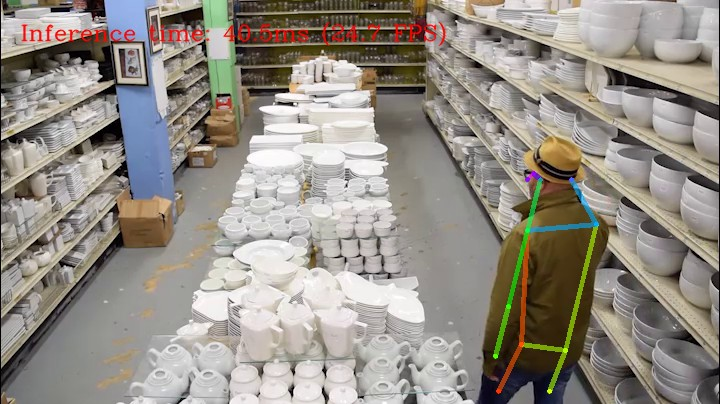

Interrupted


In [19]:
USE_WEBCAM = False
cam_id = 0
video_file = "https://storage.openvinotoolkit.org/data/test_data/videos/store-aisle-detection.mp4"
source = cam_id if USE_WEBCAM else video_file

additional_options = {"skip_first_frames": 500} if not USE_WEBCAM else {}
run_pose_estimation(source=source, flip=isinstance(source, int), use_popup=False, **additional_options)